### Trabalho final - Disciplina "Processamento distribuído"

###Alunos:

- Benício Bezerra de Abreu Carneiro (Matrícula: 2419566-0)
- Felipe Alves da Silva (Matrícula: 2329032)
- Gabriel Façanha Leal (Matrícula: 2328556)
- Marcos Andre Pires da Silva Junior (Matrícula: 2419159)
_________________________________________________

Assunto: Simulação de Vendas de Carros

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, month, dayofweek, avg
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd

### Obtenção de dados para análises

In [0]:
# Função para gerar dados simulados
def generate_car_sales_data(num_records):
    brands = ['Toyota', 'Ford', 'BMW', 'Audi', 'Chevrolet']
    models = ['Model A', 'Model B', 'Model C', 'Model D', 'Model E']
    data = []
    base_date = datetime(2024, 1, 1)

    for _ in range(num_records):
        brand = random.choice(brands)
        model = random.choice(models)
        value = round(random.uniform(20000, 50000), 2)
        quantity = random.randint(1, 10)
        date = base_date + timedelta(days=random.randint(0, 180))
        data.append((brand, model, value, quantity, date))

    return data

In [0]:
# Inicializar o SparkSession
spark = SparkSession.builder.appName("CarSalesSimulation").getOrCreate()

# Gerar 10.000 registros de vendas simuladas
data = generate_car_sales_data(10000)

# Criar DataFrame
columns = ['Brand', 'Model', 'Value', 'Quantity', 'Date']
df = spark.createDataFrame(data, columns)

# Mostrar as primeiras linhas do DataFrame
df.show(5)

+---------+-------+--------+--------+-------------------+
|    Brand|  Model|   Value|Quantity|               Date|
+---------+-------+--------+--------+-------------------+
|      BMW|Model C|32741.05|       3|2024-04-26 00:00:00|
|      BMW|Model D|24338.47|       6|2024-01-10 00:00:00|
|     Audi|Model E|41597.52|       6|2024-03-16 00:00:00|
|Chevrolet|Model E|44215.02|       2|2024-06-23 00:00:00|
|     Ford|Model B|30980.44|      10|2024-05-27 00:00:00|
+---------+-------+--------+--------+-------------------+
only showing top 5 rows



### Uso/Prática de funções com Spark

In [0]:
# Calcular receita total por marca
df_grouped_by_brand = df.groupBy('Brand').sum('Value').withColumnRenamed('sum(Value)', 'TotalRevenue')
df_grouped_by_brand.show()


+---------+-------------------+
|    Brand|       TotalRevenue|
+---------+-------------------+
|Chevrolet|7.011485942000003E7|
|     Audi|7.104507803000002E7|
|      BMW|6.840296402999997E7|
|   Toyota|      6.928775341E7|
|     Ford|7.262461535999997E7|
+---------+-------------------+



In [0]:
# Calcular quantidade total vendida por modelo
df_grouped_by_model = df.groupBy('Model').sum('Quantity').withColumnRenamed('sum(Quantity)', 'TotalQuantity')
df_grouped_by_model.show()

+-------+-------------+
|  Model|TotalQuantity|
+-------+-------------+
|Model E|        10915|
|Model B|        11219|
|Model D|        11172|
|Model A|        11209|
|Model C|        10753|
+-------+-------------+



In [0]:

# Coletar dados para gráficos
brand_df = df_grouped_by_brand.toPandas()
model_df = df_grouped_by_model.toPandas()


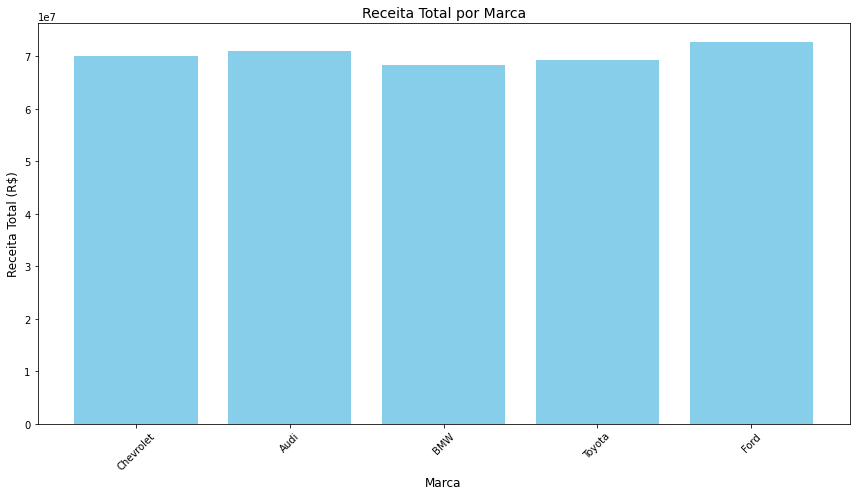

In [0]:
# Gráfico de Receita Total por Marca
plt.figure(figsize=(12, 7))
plt.bar(brand_df['Brand'], brand_df['TotalRevenue'], color='skyblue')
plt.xlabel('Marca', fontsize=12)
plt.ylabel('Receita Total (R$)', fontsize=12)
plt.title('Receita Total por Marca', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

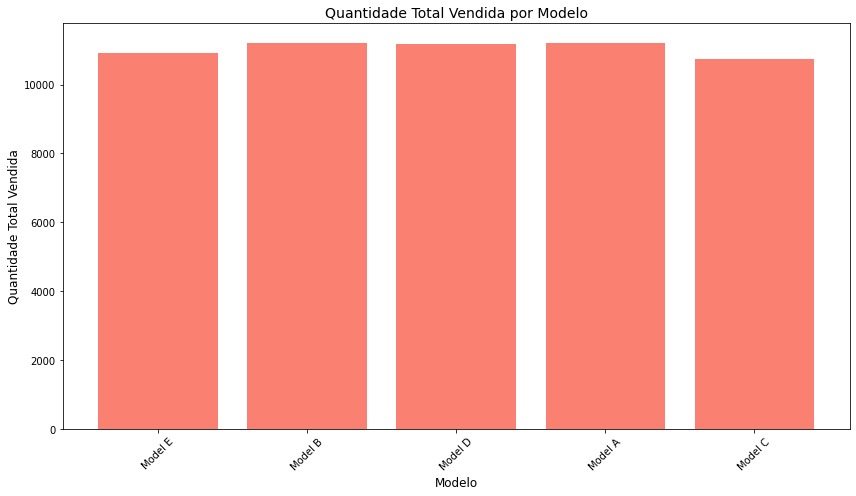

In [0]:
# Gráfico de Quantidade Total Vendida por Modelo
plt.figure(figsize=(12, 7))
plt.bar(model_df['Model'], model_df['TotalQuantity'], color='salmon')
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Quantidade Total Vendida', fontsize=12)
plt.title('Quantidade Total Vendida por Modelo', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [0]:
# Adicionar colunas para mês e dia da semana
df = df.withColumn('Month', month(col('Date')))
df = df.withColumn('DayOfWeek', dayofweek(col('Date')))

# Vendas totais por mês
df_monthly = df.groupBy('Month').sum('Value').withColumnRenamed('sum(Value)', 'TotalRevenue')
df_monthly = df_monthly.orderBy('Month')  # Ordenar por mês
df_monthly_df = df_monthly.toPandas()

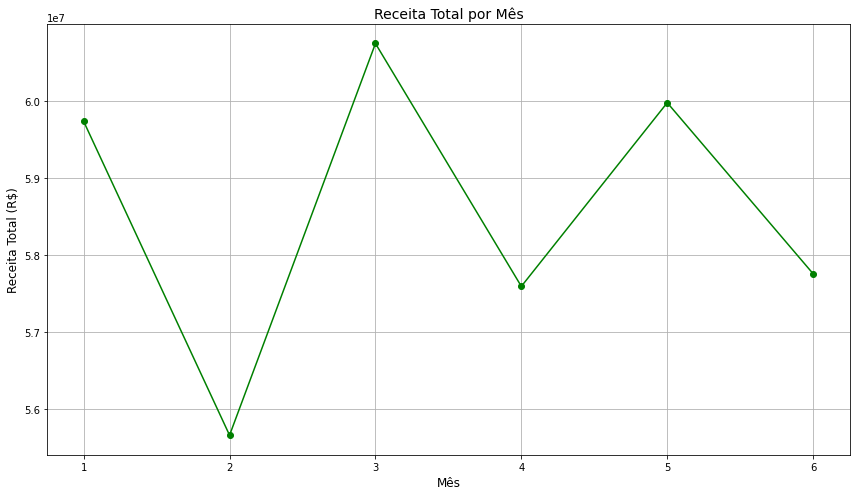

In [0]:
# Gráfico de Receita Total por Mês
plt.figure(figsize=(12, 7))
plt.plot(df_monthly_df['Month'], df_monthly_df['TotalRevenue'], marker='o', linestyle='-', color='green')
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Receita Total (R$)', fontsize=12)
plt.title('Receita Total por Mês', fontsize=14)
plt.xticks(df_monthly_df['Month'])
plt.grid(True)
plt.tight_layout()
plt.show()

In [0]:
# Vendas totais por dia da semana
df_weekly = df.groupBy('DayOfWeek').sum('Value').withColumnRenamed('sum(Value)', 'TotalRevenue')
df_weekly = df_weekly.orderBy('DayOfWeek')  # Ordenar por dia da semana
df_weekly_df = df_weekly.toPandas()

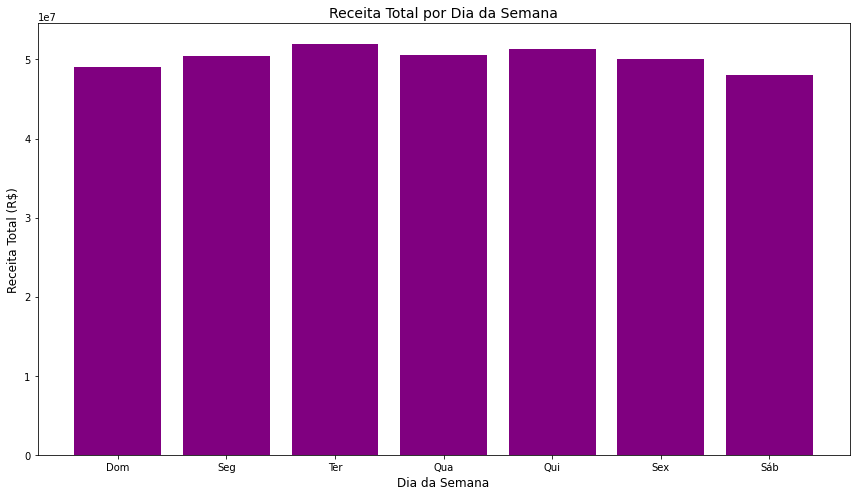

In [0]:
# Gráfico de Receita Total por Dia da Semana
plt.figure(figsize=(12, 7))
plt.bar(df_weekly_df['DayOfWeek'], df_weekly_df['TotalRevenue'], color='purple')
plt.xlabel('Dia da Semana', fontsize=12)
plt.ylabel('Receita Total (R$)', fontsize=12)
plt.title('Receita Total por Dia da Semana', fontsize=14)
plt.xticks(df_weekly_df['DayOfWeek'], ['Dom', 'Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb'])
plt.tight_layout()
plt.show()

In [0]:
# Análise de Tendências
# Receita média mensal
df_monthly_avg = df.groupBy('Month').agg(avg('Value').alias('AverageMonthlyRevenue'))
df_monthly_avg = df_monthly_avg.orderBy('Month')  # Ordenar por mês
df_monthly_avg_df = df_monthly_avg.toPandas()

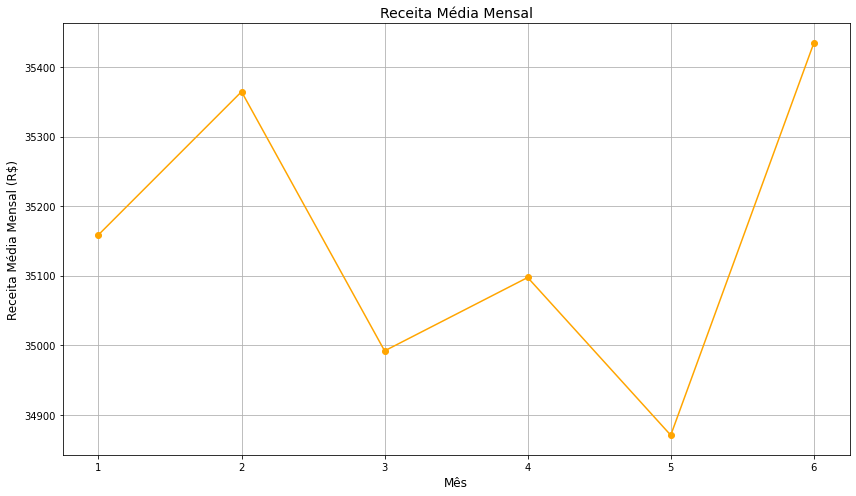

In [0]:
# Gráfico de Receita Média por Mês
plt.figure(figsize=(12, 7))
plt.plot(df_monthly_avg_df['Month'], df_monthly_avg_df['AverageMonthlyRevenue'], marker='o', linestyle='-', color='orange')
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Receita Média Mensal (R$)', fontsize=12)
plt.title('Receita Média Mensal', fontsize=14)
plt.xticks(df_monthly_avg_df['Month'])
plt.grid(True)
plt.tight_layout()
plt.show()

### Exportação de dados para CSV/Parquet

In [0]:
# Consolidar todos os dados finais em um único DataFrame
df_final = df_grouped_by_brand.join(df_grouped_by_model, on=None, how='outer') \
    .join(df_monthly, on=None, how='outer') \
    .join(df_weekly, on=None, how='outer') \
    .join(df_monthly_avg, on=None, how='outer')

In [0]:
# Renomear as colunas para evitar conflitos e facilitar a exportação
df_final = df_final.withColumnRenamed('TotalRevenue', 'TotalRevenue_Brand') \
                   .withColumnRenamed('TotalQuantity', 'TotalQuantity_Model') \
                   .withColumnRenamed('TotalRevenue', 'TotalRevenue_Month') \
                   .withColumnRenamed('TotalRevenue', 'TotalRevenue_Week') \
                   .withColumnRenamed('AverageMonthlyRevenue', 'AverageMonthlyRevenue')

In [0]:
# Exibir o DataFrame final
df_final.show()

+---------+-------------------+-------+-------------------+-----+------------------+---------+--------------------+-----+---------------------+
|    Brand| TotalRevenue_Brand|  Model|TotalQuantity_Model|Month|TotalRevenue_Brand|DayOfWeek|  TotalRevenue_Brand|Month|AverageMonthlyRevenue|
+---------+-------------------+-------+-------------------+-----+------------------+---------+--------------------+-----+---------------------+
|Chevrolet|7.011485942000003E7|Model E|              10915|    1|     5.973477293E7|        1|       4.906615446E7|    1|    35158.78336080047|
|Chevrolet|7.011485942000003E7|Model E|              10915|    1|     5.973477293E7|        1|       4.906615446E7|    6|   35434.633993865034|
|Chevrolet|7.011485942000003E7|Model E|              10915|    1|     5.973477293E7|        1|       4.906615446E7|    3|    34991.85174539169|
|Chevrolet|7.011485942000003E7|Model E|              10915|    1|     5.973477293E7|        1|       4.906615446E7|    5|   34870.596180

In [0]:
# Exportar para CSV
df.write.csv('/dbfs/data_car_sales.csv', header=True)

In [0]:
# Exportar para Parquet
df.write.parquet('/dbfs/data_car_sales.parquet')

In [0]:
# Verificação de diretório
dbutils.fs.ls("/dbfs")

Out[31]: [FileInfo(path='dbfs:/dbfs/data_car_sales.csv/', name='data_car_sales.csv/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/dbfs/data_car_sales.parquet/', name='data_car_sales.parquet/', size=0, modificationTime=0)]